In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import os

import matplotlib 
import matplotlib.pyplot as plt

import tensorflow as tf 
import keras 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau


from keras.datasets import mnist

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical 

import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# Cargamos el scaler que usamos para escalar los datos previamente

with open('escaladores/x_scaler.pkl', 'rb') as file:
    x_scaler = pickle.load(file)
    
with open('escaladores/y_scaler.pkl', 'rb') as file:
    y_scaler = pickle.load(file)

In [4]:
df = pd.read_csv("../bin/data_process.csv")

In [5]:
# Quitamos el precio nuevo porque a Miguel le parece que es hacer trampa

x = df.drop(columns = ['precio_contado'], axis=1)  
y = df['precio_contado']  

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=33)

In [6]:
# Definir un EarlyStopping para detener el entrenamiento si la pérdida no mejora

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose = 1)

In [7]:
reduce_lr = ReduceLROnPlateau(
    # Métrica a monitorear (generalmente 'val_loss')
    monitor='val_loss', 
    # Factor por el cual se reduce el learning rate (LR = LR * factor)
    factor=0.75, 
    # Número de épocas sin mejora antes de reducir el LR
    patience=4,  
    # Valor mínimo que puede alcanzar el learning rate
    min_lr=0.00001,      
    # Imprime mensajes cuando se reduce el LR
    verbose=1                  
)

In [8]:
def crear_modelo(input_dim=x_train.shape[1], learning_rate=0.001, func_loss='mse', filename='model.keras'):
    """
    Crea una red neuronal para regresión y guarda el modelo en un archivo.

    Parámetros:
    - input_dim (int): Número de características de entrada.
    - learning_rate (float): Tasa de aprendizaje para el optimizador Adam.
    - func_loss (str): Función de pérdida ('mse' o 'mae').
    - filename (str): Nombre del archivo para guardar el modelo.

    Retorno:
    - model (keras.Sequential): Modelo compilado.
    """

    model = Sequential()

    model.add(Input(shape=(input_dim,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='linear'))

    optimizer = Adam(learning_rate=learning_rate)

    if func_loss == 'mse':
        model.compile(optimizer=optimizer, loss='mse', metrics=['mean_absolute_error'])
    else:
        model.compile(optimizer=optimizer, loss='mae', metrics=['mean_squared_error'])

    # Guarda el modelo en el archivo especificado
    model.save(filename)

    return model


In [9]:
def entrenamiento(modelo, filename='resultados.pkl', historial_filename='historial_entrenamiento.pkl'):
    """
    Entrena el modelo y guarda tanto las métricas finales como el historial completo del entrenamiento.
    
    También grafica la evolución de la pérdida durante el entrenamiento y guarda los resultados en archivos .pkl.

    Parámetros:
    - modelo: El modelo de red neuronal a entrenar.
    - filename (str): Nombre del archivo para guardar las métricas finales, debe incluir la extensión .pkl.
    - historial_filename (str): Nombre del archivo para guardar el historial completo, debe incluir la extensión .pkl.

    Retorna:
    - resultados: DataFrame con el número de épocas y las métricas finales (MSE y MAE).
    """
    initial_learning_rate = modelo.optimizer.learning_rate.numpy()
    
    # Entrenar el modelo
    history = modelo.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Guardar el historial completo del entrenamiento
    with open(historial_filename, 'wb') as file:
        pickle.dump(history.history, file)

    # Obtener el número de épocas que ha tardado en llegar al plateau
    epochs_run = len(history.history['loss'])

    # Obtener las métricas finales
    metrics = modelo.evaluate(x_test, y_test, verbose=0)

    # Crear un resumen con las métricas finales
    resultados = pd.DataFrame({
        'Número de épocas': [epochs_run],
        'MSE final': [metrics[0]],
        'MAE final': [metrics[1]]
    })

    # Guardar el resumen en el archivo especificado con formato .pkl
    resultados.to_pickle(filename)

    loss_name = modelo.loss.upper()

    final_learning_rate = modelo.optimizer.learning_rate.numpy()
    
    # Graficar la evolución de la pérdida
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label=f'{loss_name} (Entrenamiento)')
    plt.plot(history.history['val_loss'], label=f'{loss_name} (Validación)')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    if initial_learning_rate == final_learning_rate:
        plt.title(f'Evolución de la pérdida durante el entrenamiento\nLearning rate: {initial_learning_rate * 100:.2f}%')
    else: 
        plt.title(
            f'Evolución de la pérdida durante el entrenamiento\n'
            f'Learning rate inicial: {initial_learning_rate * 100:.2f}%, '
            f'final: {final_learning_rate * 100:.2f}%'
        )
    plt.show()
    
    return resultados

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5339 - mean_absolute_error: 0.5070 - val_loss: 0.1774 - val_mean_absolute_error: 0.2882 - learning_rate: 0.0050
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2830 - mean_absolute_error: 0.3639 - val_loss: 0.2313 - val_mean_absolute_error: 0.3234 - learning_rate: 0.0050
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2739 - mean_absolute_error: 0.3567 - val_loss: 0.1520 - val_mean_absolute_error: 0.2713 - learning_rate: 0.0050
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2162 - mean_absolute_error: 0.3250 - val_loss: 0.1626 - val_mean_absolute_error: 0.2671 - learning_rate: 0.0050
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2137 - mean_absolute_error: 0.3204 - val_loss: 0.1483 - val_mean_absolute_error: 0.2659 - learning_rate: 0.0050
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2008 - mean_absolute_error: 0.3127 - val_loss: 0.1333 - val_me

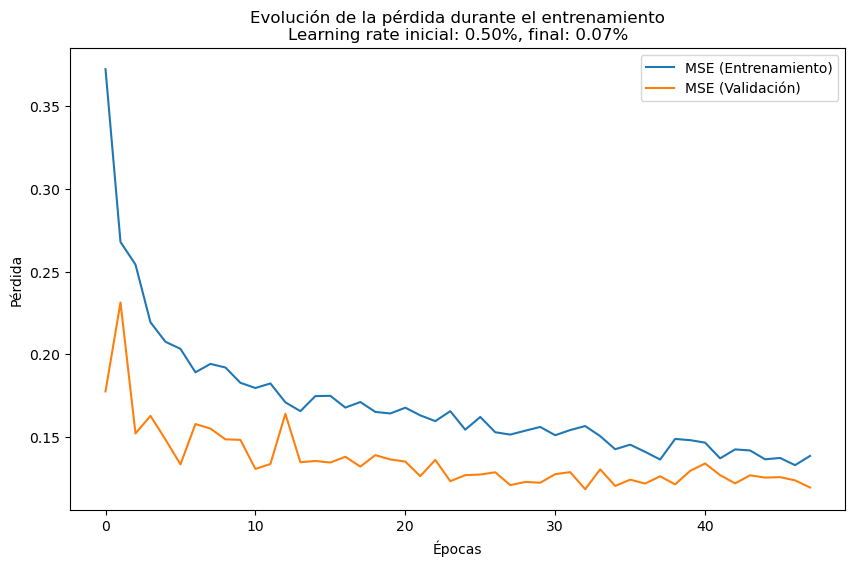

   Número de épocas  MSE final  MAE final
0                48   0.118193   0.231504


In [10]:
neural_mse = crear_modelo(learning_rate= 0.005, filename='modelo/neural_mse.keras')

resultados_entrenamiento = entrenamiento(neural_mse, filename='modelo/resultados_neural_mse.pkl', historial_filename='modelo/historial_neural_mse.pkl')

print(resultados_entrenamiento)

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5447 - mean_absolute_error: 0.5417 - val_loss: 0.1604 - val_mean_absolute_error: 0.2694 - learning_rate: 0.0030
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2658 - mean_absolute_error: 0.3614 - val_loss: 0.1591 - val_mean_absolute_error: 0.2746 - learning_rate: 0.0030
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2520 - mean_absolute_error: 0.3486 - val_loss: 0.1469 - val_mean_absolute_error: 0.2607 - learning_rate: 0.0030
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2257 - mean_absolute_error: 0.3319 - val_loss: 0.1469 - val_mean_absolute_error: 0.2566 - learning_rate: 0.0030
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2172 - mean_absolute_error: 0.3229 - val_loss: 0.1448 - val_mean_absolute_error: 0.2573 - learning_rate: 0.0030
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1993 - mean_absolute_error: 0.3123 - val_loss: 0.1581 - val_me

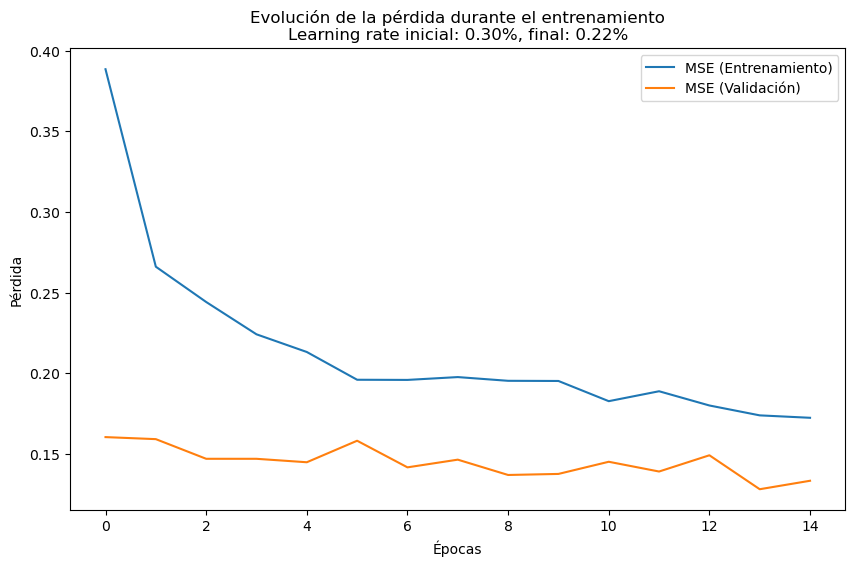

   Número de épocas  MSE final  MAE final
0                15   0.160386   0.269423


In [11]:
neural_mse_2 = crear_modelo(learning_rate= 0.003, filename='modelo/neural_mse_2.keras')

resultados_entrenamiento = entrenamiento(neural_mse_2, filename='modelo/resultados_neural_mse_2.pkl', historial_filename='modelo/historial_neural_mse_2.pkl')
print(resultados_entrenamiento)

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4931 - mean_absolute_error: 0.5003 - val_loss: 0.1783 - val_mean_absolute_error: 0.2703 - learning_rate: 0.0035
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2696 - mean_absolute_error: 0.3486 - val_loss: 0.1571 - val_mean_absolute_error: 0.2709 - learning_rate: 0.0035
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2300 - mean_absolute_error: 0.3339 - val_loss: 0.1627 - val_mean_absolute_error: 0.2709 - learning_rate: 0.0035
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2126 - mean_absolute_error: 0.3247 - val_loss: 0.1464 - val_mean_absolute_error: 0.2632 - learning_rate: 0.0035
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2164 - mean_absolute_error: 0.3222 - val_loss: 0.1547 - val_mean_absolute_error: 0.2729 - learning_rate: 0.0035
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1860 - mean_absolute_error: 0.3028 - val_loss: 0.1397 - val_me

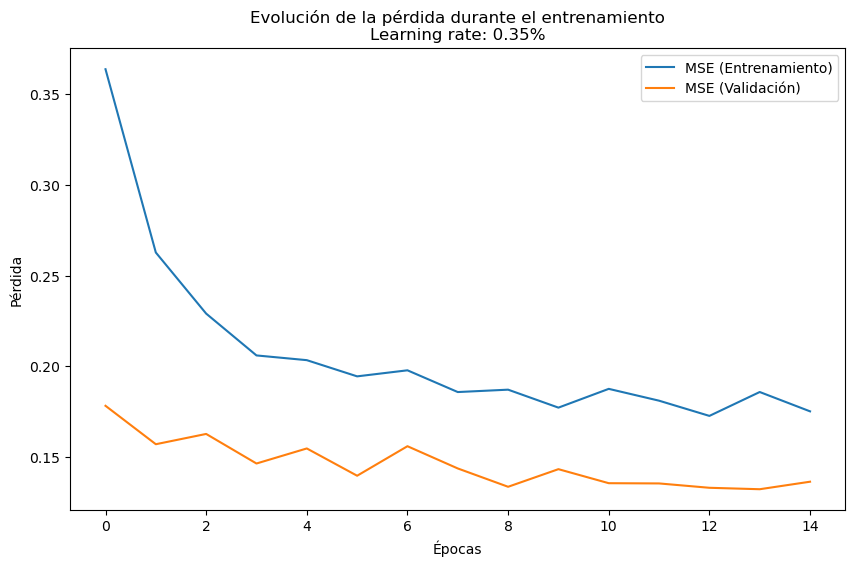

   Número de épocas  MSE final  MAE final
0                15    0.17825    0.27028


In [12]:
neural_mse_3 = crear_modelo(learning_rate= 0.0035, filename='modelo/neural_mse_3.keras')

resultados_entrenamiento = entrenamiento(neural_mse_3, filename='modelo/resultados_neural_mse_3.pkl', historial_filename='modelo/historial_neural_mse_3.pkl')
print(resultados_entrenamiento)

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5143 - mean_squared_error: 0.5322 - val_loss: 0.2941 - val_mean_squared_error: 0.1978 - learning_rate: 0.0050
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3596 - mean_squared_error: 0.2904 - val_loss: 0.2635 - val_mean_squared_error: 0.1504 - learning_rate: 0.0050
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3378 - mean_squared_error: 0.2512 - val_loss: 0.3015 - val_mean_squared_error: 0.1989 - learning_rate: 0.0050
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3297 - mean_squared_error: 0.2350 - val_loss: 0.2939 - val_mean_squared_error: 0.1837 - learning_rate: 0.0050
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3206 - mean_squared_error: 0.2237 - val_loss: 0.2703 - val_mean_squared_error: 0.1511 - learning_rate: 0.0050
Epoch 6/100
109/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3128 - mean_squared_error: 0.2103
Epoch 6: ReduceLROnPlateau reducing le

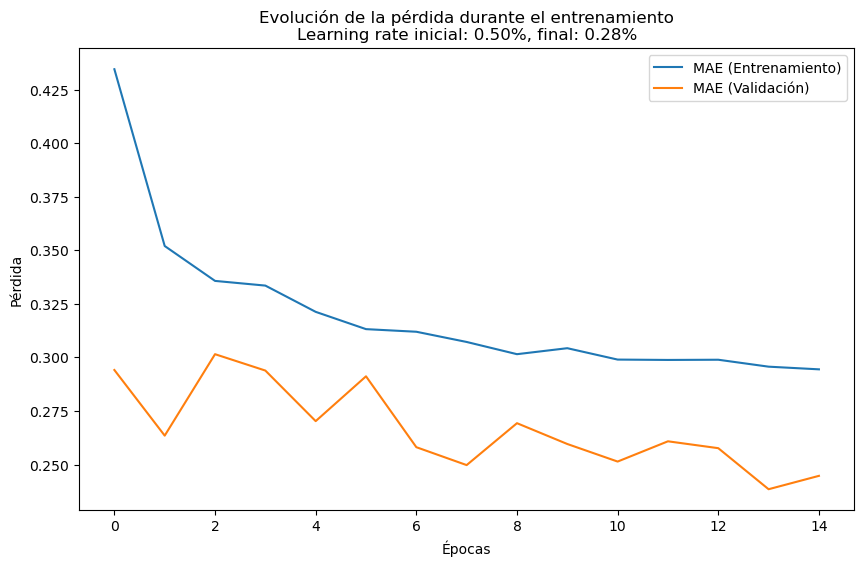

   Número de épocas  MSE final  MAE final
0                15   0.294144    0.19783


In [13]:
neural_mae_1 = crear_modelo(learning_rate= 0.005, func_loss = 'mae' , filename='modelo/neural_mae_1.keras')

resultados_entrenamiento = entrenamiento(neural_mae_1, filename='modelo/resultados_neural_mae_1.pkl', historial_filename='modelo/historial_neural_mae_1.pkl')
print(resultados_entrenamiento)

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5077 - mean_squared_error: 0.5260 - val_loss: 0.3049 - val_mean_squared_error: 0.1949 - learning_rate: 0.0030
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3530 - mean_squared_error: 0.2581 - val_loss: 0.2866 - val_mean_squared_error: 0.1764 - learning_rate: 0.0030
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3350 - mean_squared_error: 0.2377 - val_loss: 0.2637 - val_mean_squared_error: 0.1604 - learning_rate: 0.0030
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3302 - mean_squared_error: 0.2438 - val_loss: 0.2741 - val_mean_squared_error: 0.1722 - learning_rate: 0.0030
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3202 - mean_squared_error: 0.2281 - val_loss: 0.2531 - val_mean_squared_error: 0.1497 - learning_rate: 0.0030
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3123 - mean_squared_error: 0.2080 - val_loss: 0.2653 - val_mean_squared_

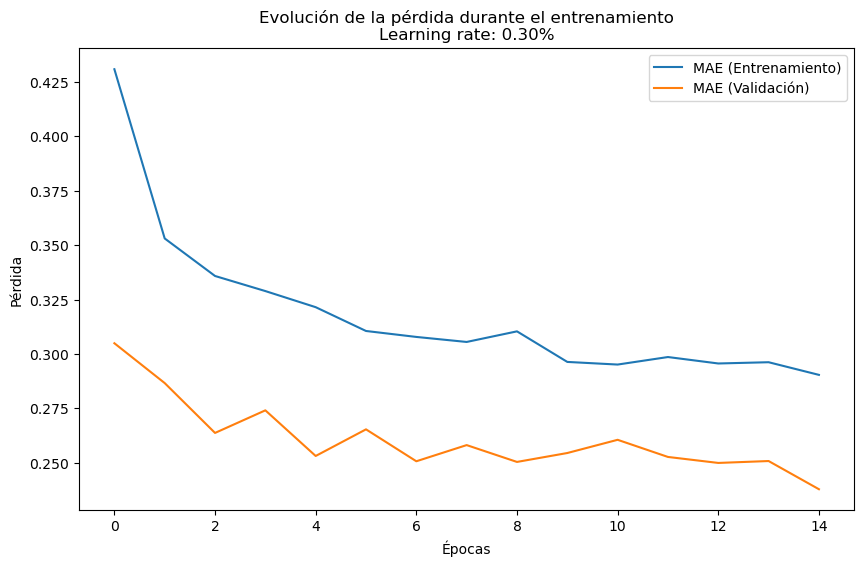

   Número de épocas  MSE final  MAE final
0                15   0.304896   0.194912


In [14]:
neural_mae_2 = crear_modelo(learning_rate= 0.003, func_loss = 'mae', filename='modelo/neural_mae_2.keras')

resultados_entrenamiento = entrenamiento(neural_mae_2, filename='modelo/resultados_neural_mae_2.pkl', historial_filename='modelo/historial_neural_mae_2.pkl')
print(resultados_entrenamiento)

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5467 - mean_squared_error: 0.5880 - val_loss: 0.3060 - val_mean_squared_error: 0.2246 - learning_rate: 0.0035
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3557 - mean_squared_error: 0.2865 - val_loss: 0.2780 - val_mean_squared_error: 0.1765 - learning_rate: 0.0035
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3338 - mean_squared_error: 0.2330 - val_loss: 0.2936 - val_mean_squared_error: 0.1728 - learning_rate: 0.0035
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3272 - mean_squared_error: 0.2318 - val_loss: 0.2547 - val_mean_squared_error: 0.1546 - learning_rate: 0.0035
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3036 - mean_squared_error: 0.2041 - val_loss: 0.2864 - val_mean_squared_error: 0.2164 - learning_rate: 0.0035
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2995 - mean_squared_error: 0.1959 - val_loss: 0.2503 - val_mean_squared_

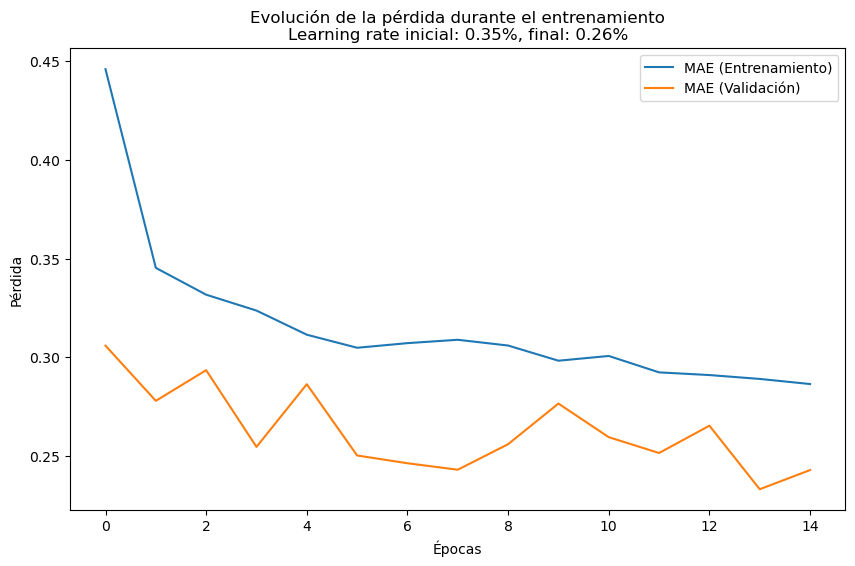

   Número de épocas  MSE final  MAE final
0                15   0.305966   0.224617


In [15]:
neural_mae_3 = crear_modelo(learning_rate= 0.0035, func_loss = 'mae', filename='modelo/neural_mae_3.keras')

resultados_entrenamiento = entrenamiento(neural_mae_3, filename='modelo/resultados_neural_mae_3.pkl', historial_filename='modelo/historial_neural_mae_3.pkl')
print(resultados_entrenamiento)

In [16]:
neural_mse.save('modelo/red_neuronal.keras')